<B> 1. Importing all the dependencies for this Project </B>

In [1]:
#!pip install tensorflow tensorflow-gpu 
#pip install pandas 
#pip install matplotlib 
#pip install sklearn

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
#df = pd.read_csv('C:/Users/harsh/Deep Learning/Comment Toxicity Detection/train.csv')
df=pd.read_csv(r"C:\Users\harsh\Deep Learning\Comment Toxicity Detection\train.csv")
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
# Splitting the dataset into dependent and independent variables
X = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000 # number of words in the vocab

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [8]:
vectorizer.adapt(X.values)


In [9]:
vectorized_text = vectorizer(X.values)


In [10]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [11]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

<b> 2. Creating Sequential Model </b>

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [13]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))


In [14]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [15]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 8719s 1s/step - loss: 0.0614 - val_loss: 0.0481


<Figure size 800x500 with 0 Axes>

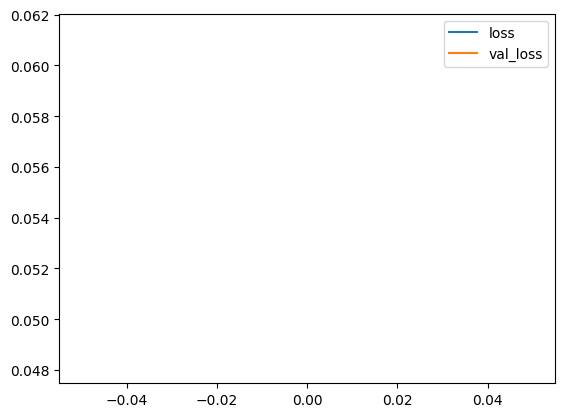

In [17]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()


In [12]:
from tensorflow.keras.models import load_model

In [13]:
model.save("comment_toxicity.h5")

NameError: name 'model' is not defined

<b> 3. Make Predictions </b>

In [14]:
model= load_model('comment_toxicity.h5')

In [15]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
#res = model.predict(input_text)
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [16]:
res = model.predict(np.array([input_text]))
res

1/1 [==============================] - 1s 1s/step


array([[0.99447525, 0.46161047, 0.9437316 , 0.06088163, 0.84409684,
        0.22186556]], dtype=float32)

In [17]:
print((res > 0.5).astype(int))
batch_X, batch_y = test.as_numpy_iterator().next()
print((model.predict(batch_X) > 0.5).astype(int))
print(res.shape)

[[1 0 1 0 1 0]]
1/1 [==============================] - 0s 242ms/step
[[1 1 1 0 1 0]
 [1 1 1 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]]
(1, 6)


<b> 4. Evaluate Model </b>

In [18]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [19]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [20]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 133ms/step


In [21]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7472810745239258, Recall:0.7683931589126587, Accuracy:0.48946839570999146


In [22]:
!pip install gradio jinja2

     ---------------------------------------- 11.6/11.6 MB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 85.0/85.0 kB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 8.6 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 54.9/54.9 kB ? eta 0:00:00
     ---------------------------------------- 55.5/55.5 kB 2.8 MB/s eta 0:00:00
     -------------------------------------- 101.4/101.4 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 56.9/56.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 84.5/84.5 kB 5.0 MB/s eta 0:00:00
     ------------------------------------- 213.1/213.1 kB 13.5 MB/s eta 0:00:00
     --

In [23]:
import tensorflow as tf
import gradio as gr


ModuleNotFoundError: No module named 'gradio'